## Generate Pangolin similar data for training

In [1]:
import os
import pandas as pd
import numpy as np
import gffutils
import glob
from pyfaidx import Fasta
from collections import defaultdict
import os
import gzip
import requests
from tqdm import tqdm

from packages.data_utils import *
from packages.visual_utils import *

In [2]:
# Step 1: Download files from GENcode if not exist

####### Change as needed ########
rl_version = '49'
db_home = os.path.join(os.path.expanduser('~'), f'database/genomes')
genome_fasta_path = os.path.join(db_home, 'GRCh37.primary_assembly.genome.fa')
genome_fasta_index_path = genome_fasta_path + '.fai'

gencode_gff3_path = os.path.join(db_home, f'gencode.v{rl_version}lift37.annotation.gff3')
gencode_gtf_path = os.path.join(db_home, f'gencode.v{rl_version}lift37.annotation.gtf')
gencode_gtf_db_path = os.path.basename(gencode_gtf_path) + '.db'
####### No need to change below (ideally) ########

def download_file(url, local_path):
    response = requests.get(url, stream=True)
    with open(local_path, 'wb') as file:
        print(f"Downloading {url}\n to {local_path}...")
        for chunk in response.iter_content(chunk_size=8192):
            file.write(chunk)
    print(f"Downloaded {url}\n to {local_path}")

# Download and unzip file if not exist
for db_path in [genome_fasta_path, gencode_gff3_path, gencode_gtf_path]:
    if not os.path.exists(db_path):
        os.makedirs(db_home, exist_ok=True)
        url = f'https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_{rl_version}/{db_path.split("/")[-1]}.gz'
        # https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_49/gencode.v49.annotation.gtf.gz
        # https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_49/GRCh38.primary_assembly.genome.fa.gz
        local_gz_path = db_path + '.gz'
        download_file(url, local_gz_path)
        with gzip.open(local_gz_path, 'rb') as f_in:
            with open(db_path, 'wb') as f_out:
                f_out.write(f_in.read())
        os.remove(local_gz_path)
    else:
        print(f"File {db_path} already exists. Skipping download.")


# generate fai file from fa file
if not os.path.exists(genome_fasta_index_path):
    print(f"Creating FAI index for {genome_fasta_path}...")
    os.system(f'samtools faidx {genome_fasta_path}')
else:
    print(f"FAI index file exists: {genome_fasta_index_path}")

# generate annotation db
if not os.path.exists(gencode_gtf_db_path):
    print(f"Creating gffutils database from {gencode_gtf_path}...")

    # Only keep GTF features with the specified tags. Format: tag1,tag2,... or None to keep all features
    filter_tags ="Ensembl_canonical"

    # Copied from Pangolin create_db.py
    def gtf_filter_fn(feat):

        # correct gene_id from lift37 to remove mapping version suffixes
        # e.g., ENSG00000121410.12_2 -> ENSG00000121410.12
        gene_id = feat.attributes.get("gene_id")
        if gene_id and gene_id[0].count('_') == 1: # some gene_ids end with _PAR_Y
                feat.attributes["gene_id"][0] = gene_id[0].split('_')[0]

        if feat.featuretype not in ["gene","transcript","exon"]:
            return False
        elif filter_tags != "None" and feat.featuretype in ["transcript", "exon"]:
            present = False
            for tag in filter_tags.split(','):
                if "tag" in feat.attributes and tag in feat["tag"]:
                    present = True
            if not present:
                return False
        return feat

    db = gffutils.create_db(gencode_gtf_path, gencode_gtf_db_path, force=True,
                            disable_infer_genes=True, disable_infer_transcripts=True,
                            transform=gtf_filter_fn)

    print(f"Database created: {gencode_gtf_db_path}")
else:
    print(f"GFFUtils database exists: {gencode_gtf_db_path}")

File /home/xqiu/database/genomes/GRCh37.primary_assembly.genome.fa already exists. Skipping download.
File /home/xqiu/database/genomes/gencode.v49lift37.annotation.gff3 already exists. Skipping download.
File /home/xqiu/database/genomes/gencode.v49lift37.annotation.gtf already exists. Skipping download.
FAI index file exists: /home/xqiu/database/genomes/GRCh37.primary_assembly.genome.fa.fai
GFFUtils database exists: gencode.v49lift37.annotation.gtf.db


In [3]:
# tsv_file = os.path.join(os.getcwd(), "data/Human/E-MTAB-6814/spliser_heart.All.DiffSpliSER.tsv")
tsv_file = os.path.join(os.getcwd(), "data/Human/E-MTAB-6814/spliser_heart.combined.tsv")

spliser_df = pd.read_csv(tsv_file, sep='\t', comment='#')

junc_columns = ['Sample', 'Region', 'Site', 'Strand', 'Gene', 'SSE', 'alpha_count', 'beta1_count', 'beta2_count',
                'MultiGeneFlag', 'Others', 'Partners', 'Competitors']

for col in junc_columns:
    if col not in spliser_df.columns:
        raise ValueError(f"Column {col} not found in the TSV file.")
else:
    print(f"All required columns are present in the TSV file.")

All required columns are present in the TSV file.


In [17]:
def spliser_collect_sites_single_gene(gene_id, gene_gf=None, debug=False):
    """ Collect splice site information for a single gene into a dictionary 
    Args:
        gene_id: str, gene identifier
        gene_gf: pd.DataFrame or grouped DataFrame by gene_id or None (to be loaded from file)
        debug: bool, whether to print debug information
    Returns:
        gene_sites: dict, aggregated splice site information for the gene
    """

    if gene_gf is None: # Placeholder for loading gene_df from file
        pass
    elif isinstance(gene_gf, pd.core.groupby.generic.DataFrameGroupBy):
        gene_df = gene_gf.get_group(gene_id)
    else:
        gene_df = gene_gf

    # check to make sure that all rows have the same Region and strand
    assert gene_df['Region'].nunique() == 1, "Different regions found."
    assert gene_df['Strand'].nunique() == 1, "Different strands found."

    site_gf = gene_df.groupby('Site')
    if debug:
        print(f"Total splicing sites for gene {gene_id}: {len(site_gf)}")

    # features defined per site
    site_ids = []  # chromosome positions
    site_types = []  # donor, acceptor, hybrid
    donor_counts = np.zeros(len(site_gf), dtype=int)  # number of reads supporting the site as a donor
    acceptor_counts = np.zeros(len(site_gf), dtype=int)  # number of reads supporting the site as an acceptor
    site_partners = []  # list of partner site ids

    # features defined per site per sample
    alpha_counts = []  # list of arrays, each array is [num_samples,] for a site
    beta1_counts = []  # list of arrays, each array is [num_samples,] for a site
    beta2_counts = []  # list of arrays, each array is [num_samples,] for a site

    SSEs = []  # splice-site strength estimate, list of arrays, each array is [num_samples,] for a site

    for i, (site_id, site_df) in enumerate(site_gf):

        # obtain donor and acceptor counts from Partners field for each sample and site
        partner_ids = [] # collect all partner ids for this site
        for partners_per_sample in site_df['Partners']:
            if pd.isna(partners_per_sample):
                continue
            partners_list = partners_per_sample[1:-1].split(',')
            for partner_info in partners_list:
                partner_id, partner_count = partner_info.split(':')
                partner_ids.append(partner_id)

                if int(partner_id) > site_id:
                    donor_counts[i] += int(partner_count)
                else:
                    acceptor_counts[i] += int(partner_count)

        site_partners.append('[{}]'.format(','.join(list(set(partner_ids)))))
        
        assert donor_counts[i] + acceptor_counts[i] > 0, "No donor or acceptor counts found."
        if acceptor_counts[i] == 0 or donor_counts[i] / acceptor_counts[i] > 10:
            site_id += 1 # spliser records the immediate left of the junction, while we want the donor site on the intron side
            site_type = 'donor'
        elif donor_counts[i] == 0 or acceptor_counts[i] / donor_counts[i] > 10:
            site_type = 'acceptor'
        else:
            site_type = 'hybrid'

        site_ids.append(site_id)
        site_types.append(site_type)    

        # Collect alpha, beta1, beta2 counts for each sa
        alpha_counts.append(site_df['alpha_count'].values)
        beta1_counts.append(site_df['beta1_count'].values)
        beta2_counts.append(site_df['beta2_count'].values)

        SSEs.append(site_df['SSE'].values)

    gene_sites = {
        'chrom': site_df['Region'].values[0],
        'strand': site_df['Strand'].values[0],
        'gene_id': gene_id,
        'num_sites': len(site_gf),
        'site_id': np.array(site_ids, dtype=int), # [num_sites,]
        'site_type': site_types, # [num_sites,]
        'donor_count': donor_counts, # [num_sites,]
        'acceptor_count': acceptor_counts, # [num_sites,]
        'other': site_gf['Others'].head(1).values, # [num_sites,]
        'multi_gene_flag': site_gf['MultiGeneFlag'].head(1).values, # [num_sites,]
        'partner': site_partners, # [num_sites,]
        'competitor': site_gf['Competitors'].head(1).values, # [num_sites,]
        'num_samples': len(site_df),
        'sam_names': site_df['Sample'].values, # [num_samples,]
        'alpha_count': np.stack(alpha_counts, axis=0), # [num_sites, num_samples,]
        'beta1_count': np.stack(beta1_counts, axis=0), # [num_sites, num_samples,]
        'beta2_count': np.stack(beta2_counts, axis=0), # [num_sites, num_samples,]
        'SSE': np.stack(SSEs, axis=0), # [num_sites, num_samples,]
    }
    return gene_sites

def get_gene_meta_by_id(gene_id="ENSG00000078808.20", gtf_db=None, debug=False):
    """ Get gene metadata from gtf_db by gene_id """
    # Warning: in lift37 version, the mapping version is appended to the gene_id
    # e.g., ENSG00000227232.6_8 (while spliser uses ENSG00000227232.6)

    if isinstance(gtf_db, str):
        gtf_db = gffutils.FeatureDB(gtf_db, keep_order=True)

    try:
        gene_meta = gtf_db[gene_id]
    except gffutils.FeatureNotFoundError:
        if debug:
            print(f"Skipping {gene_id} - gene not found.")
        return None
    return gene_meta

In [5]:
spliser_gf = spliser_df.groupby('Gene')
gene_ids = list(spliser_gf.groups.keys())
print(f"Total genes with splicing sites: {len(gene_ids)}")

def check_gene_in_gtf_db(gene_ids, gtf_db):
    """ Check how many genes in gene_ids are present in gtf_db """
    found_genes = 0
    for gene_id in tqdm(gene_ids):
        gene_meta = get_gene_meta_by_id(gene_id, gtf_db)
        if gene_meta is not None:
            found_genes += 1
    print(f"Found {found_genes} out of {len(gene_ids)} genes in GTF database.")

gtf_db = gffutils.FeatureDB(gencode_gtf_db_path, keep_order=True)
check_gene_in_gtf_db(gene_ids, gtf_db)

Total genes with splicing sites: 38096


100%|██████████| 38096/38096 [00:06<00:00, 5643.54it/s]

Found 38095 out of 38096 genes in GTF database.


In [ ]:
# check if running in jupyter-notebook
try:
    get_ipython
    in_notebook = True
except NameError:
    in_notebook = False

if in_notebook:
    print("Running in Jupyter Notebook.")
    gene_sites_list = []
    for gene_id in tqdm(gene_ids):
        gene_sites = spliser_collect_sites_single_gene(gene_id, gene_gf=spliser_gf, debug=False)
        gene_sites_list.append(gene_sites)
else:
    import functools
    import misc
    gene_sites_list = misc.mpi_map(functools.partial(spliser_collect_sites_single_gene, gene_gf=spliser_gf), tqdm(gene_ids))
    
gene_sites_df = pd.DataFrame(gene_sites_list)
gene_sites_df.to_pickle('gene_sites.pkl')
print(f"Saved gene_sites_list to gene_sites.pkl")    

100%|██████████| 38096/38096 [06:11<00:00, 102.47it/s]


Saved gene_sites_list to gene_sites.pkl


In [16]:
def retrieve_gene_meta_sequence(gene_sites, gtf_db=None, genome_fasta=None, debug=False):
    """ Retrieve gene sequence from genome fasta file using gene metadata from gtf_db.
    Args:
        gene_sites: dict, e.g., output of spliser_aggregate_sites_single_gene
        gtf_db: gffutils.FeatureDB or path to gtf_db
        genome_fasta: path to genome fasta file or pyfaidx.Fasta object
        debug: bool, whether to print debug information
    Returns:
        gene_sites: dict, updated with gene sequence and metadata
    """
    
    gene_id = gene_sites['gene_id']

    # Retrieve gene metadata from GTF database
    gene_meta = get_gene_meta_by_id(gene_id, gtf_db)
    gene_sites['gene_not_found'] = gene_meta is None

    if gene_meta is None:
        if debug:
            print(f"Gene {gene_id} not found in GTF database, returning None.")
        return gene_sites

    gene_len = gene_meta.end - gene_meta.start + 1

    assert gene_meta.chrom == gene_sites['chrom'], f"Chromosome mismatch: {gene_meta.chrom} vs {gene_sites['chrom']}"
    assert gene_meta.strand == gene_sites['strand'], f"Strand mismatch: {gene_meta.strand} vs {gene_sites['strand']}"

    # get gene transcript sequence from genome_fasta
    if isinstance(genome_fasta, str):
        genome_fasta = Fasta(genome_fasta)

    gene_seq = genome_fasta[gene_meta.chrom][gene_meta.start-1:gene_meta.end]
    if debug:
        print(f"Transcript length: {gene_len}, Gene sequence length: {len(gene_seq)}")

    gene_sites['gene_seq'] = str(gene_seq)
    gene_sites['gene_start'] = int(gene_meta.start)
    gene_sites['gene_end'] = int(gene_meta.end)
    if not all((gene_sites['site_id'] >= gene_sites['gene_start']) & (gene_sites['site_id'] <= gene_sites['gene_end'])):
        gene_sites['site_out_of_bounds'] = True
        # print(f"Warning: Some site_ids are out of gene bounds for gene {gene_id}.")
        # print(f"Gene start: {gene_sites['gene_start']}, Gene end: {gene_sites['gene_end']}")
        # print(f"Site IDs: {gene_sites['site_id']}")
    else:
        gene_sites['site_out_of_bounds'] = False
        
    return gene_sites

In [ ]:
def spliser_average_samples_and_filter_sites(
        gene_sites, # a dict, e.g., output of spliser_aggregate_sites_single_gene
        min_reads_cls = 1, # minimum reads to consider a site in a sample for classification
        min_samples_cls = 0.0, # at least 1 sample is enforced in the code
        min_reads_psi = 10, # minimum total reads to calculate usage for a site,
        min_samples_psi = 0.15, # minimum samples for usage calculation, expressed genes
        max_std_psi = 0.1, # standard deviation cutoff (not used currently)
        debug=False,
        ):
    """ Perform quality control and labeling for a single gene's splice sites """

    num_samples = gene_sites['num_samples']

    # get classification labels
    cls_mask_per_sample = gene_sites['alpha_count'] >= min_reads_cls  # shape: (num_sites, num_samples)
    cls_sample_count = np.sum(cls_mask_per_sample, axis=1) # shape: (num_sites,)
    cls_mask = cls_sample_count >= max(1, min_samples_cls * num_samples) # shape: (num_sites,)
    if debug and np.sum(cls_mask) == 0:
        print(f"No splice sites with sufficient reads in enough samples for classification for gene: {gene_sites['gene_id']}.")

    # sites with sufficient reads in enough samples
    cls_site = gene_sites['site_id'][cls_mask]
    cls_type = np.array(gene_sites['site_type'])[cls_mask]
    if debug:
        print(f"Splice sites with sufficient reads in enough samples for classification: {len(cls_site)}/{gene_sites['num_sites']}")
    cls_odds = cls_sample_count[cls_mask] / num_samples # shape: (num_gt_sites,)
    # print(f"Classification usage (pct of samples with >= {min_reads_cls} reads): {gt_cls_pct}")

    # get psi labels
    reads_per_sample = gene_sites['alpha_count'] + gene_sites['beta1_count'] + gene_sites['beta2_count'] # shape: (num_sites, num_samples)
    psi_mask_per_sample = reads_per_sample >= min_reads_psi  # shape: (num_sites, num_samples)
    psi_sample_count = np.sum(psi_mask_per_sample, axis=1) # shape: (num_sites,)
    psi_mask = psi_sample_count >= max(1, min_samples_psi * num_samples) # shape: (num_sites,)

    if debug and np.sum(psi_mask) == 0:
        print(f"No splice sites with sufficient reads in enough samples for PSI for gene: {gene_sites['gene_id']}.")

    # sites with sufficient reads in enough samples
    psi_site = gene_sites['site_id'][psi_mask]
    psi_site_type = np.array(gene_sites['site_type'])[psi_mask] # shape: (num_gt_sites,) NOT USED!
    if debug:
        print(f"Splice sites with sufficient reads in enough samples for PSI: {len(psi_site)}/{gene_sites['num_sites']}")
    psi = np.sum(gene_sites['SSE'][psi_mask, :] * 
                    psi_mask_per_sample[psi_mask, :], axis=1) / psi_sample_count[psi_mask] # shape: (num_gt_sites,)
    psi_std = np.sqrt(np.sum((gene_sites['SSE'][psi_mask, :] - psi[:, np.newaxis]) ** 2 * 
                            psi_mask_per_sample[psi_mask, :], axis=1) / psi_sample_count[psi_mask]) # shape: (num_gt_sites,)
    
    dna_sites = {
        'gene_id': gene_sites['gene_id'],
        'chrom': gene_sites['chrom'],
        'strand': gene_sites['strand'],
        'gene_seq': gene_sites['gene_seq'],
        'gene_start': gene_sites['gene_start'],
        'gene_end': gene_sites['gene_end'],
        'cls_mask_per_sample': cls_mask_per_sample,
        'cls_sample_count': cls_sample_count,
        'cls_mask': cls_mask,   
        'psi_mask_per_sample': psi_mask_per_sample,
        'psi_sample_count': psi_sample_count,
        'psi_mask': psi_mask,
        'cls_site': cls_site, # [num_sites,]
        'cls_type': cls_type,
        'cls_odds': cls_odds,
        'psi_site': psi_site,
        'psi': psi,
        'psi_std': psi_std,
    }
    return dna_sites

In [ ]:
def spliser_convert_dna_to_rna_sites(gene_sites, debug=False):
    """ Convert DNA-based splice site positions to RNA-based positions """
    rna_seq = gene_sites['gene_seq']
    dna_cls_site = gene_sites['cls_site']
    dna_cls_type = gene_sites['cls_type']
    dna_cls_odds = gene_sites['cls_odds']
    dna_psi_site = gene_sites['psi_site']
    dna_psi = gene_sites['psi']
    dna_psi_std = gene_sites['psi_std']

    # if strand is negative, reverse complement the sequence
    if gene_sites['strand'] == '-':
        rna_seq = reverse_complement(rna_seq)
        rna_cls_pos = gene_sites['gene_end'] - dna_cls_site # 0-based position in rna_seq
        rna_cls_type = ['donor' if t == 'acceptor' else 'acceptor' if t == 'donor' else t for t in dna_cls_type]
        rna_psi_pos = gene_sites['gene_end'] - dna_psi_site # 0-based position in rna_seq
    elif gene_sites['strand'] == '+':
        rna_cls_pos = dna_cls_site - gene_sites['gene_start'] # 0-based position in rna_seq
        rna_cls_type = dna_cls_type
        rna_psi_pos = dna_psi_site - gene_sites['gene_start'] # 0-based position in rna_seq
    else:
        raise ValueError(f"Invalid strand: {gene_sites['strand']}")

    if debug:
        print(f"RNA sequence length: {len(rna_seq)}, Number of classified splice sites: {len(rna_cls_pos)}")
        print(f"Number of splice sites with PSI values: {len(rna_psi_pos)}")

    rna_sites = {
        'gene_id': gene_sites['gene_id'],
        'chrom': gene_sites['chrom'],
        'strand': gene_sites['strand'],
        'gene_start': gene_sites['gene_start'],
        'gene_end': gene_sites['gene_end'],        
        'seq': rna_seq,
        'len': len(rna_seq),
        'donor': ''.join([rna_seq[pos] for pos, t in zip(rna_cls_pos, rna_cls_type) if t == 'donor']),
        'acceptor': ''.join([rna_seq[pos] for pos, t in zip(rna_cls_pos, rna_cls_type) if t == 'acceptor']),
        'hybrid': ''.join([rna_seq[pos] for pos, t in zip(rna_cls_pos, rna_cls_type) if t == 'hybrid']),
        'cls_pos': rna_cls_pos,
        'cls_type': rna_cls_type,
        'cls_odds': dna_cls_odds,
        'psi_pos': rna_psi_pos,
        'psi': dna_psi,
        'psi_std': dna_psi_std,
    }
    return rna_sites

In [55]:
failed_genes = []
rna_sites_list = []

gtf_db = gffutils.FeatureDB(gencode_gtf_db_path, keep_order=True)
genome_fasta = Fasta(genome_fasta_path)

for gene_sites in tqdm(gene_sites_list):
    gene_sites = retrieve_gene_meta_sequence(gene_sites, gtf_db, genome_fasta, debug=False)
    if gene_sites['gene_not_found'] or gene_sites['site_out_of_bounds']:
        failed_genes.append(gene_sites['gene_id'])
        continue

    dna_sites = spliser_average_samples_and_filter_sites(gene_sites, debug=False)
    rna_sites = spliser_convert_dna_to_rna_sites(dna_sites, debug=False)
    rna_sites_list.append(rna_sites)

print(f"Total genes with sequence retrieved: {len(rna_sites_list)}, Failed genes: {len(failed_genes)}")

rna_sites_df = pd.DataFrame(rna_sites_list)
rna_sites_df.to_pickle('rna_sites.pkl')
print(f"Saved rna_sites_list to rna_sites.pkl")

100%|██████████| 38096/38096 [01:56<00:00, 326.11it/s]


Total genes with sequence retrieved: 37632, Failed genes: 464
Saved rna_sites_list to rna_sites.pkl


In [56]:
from packages import splice_feats

train_feats = []
for rna_sites in tqdm(rna_sites_list[0:100]):
    rna_feats = splice_feats.sprinkle_sites_onto_vectors(rna_sites, debug=False)
    train_feats.extend(splice_feats.get_train_feats_single_rna(rna_feats, chunk_size=5000, flank_size=5000, min_sites=0, min_usage=0))

100%|██████████| 100/100 [00:00<00:00, 127.14it/s]


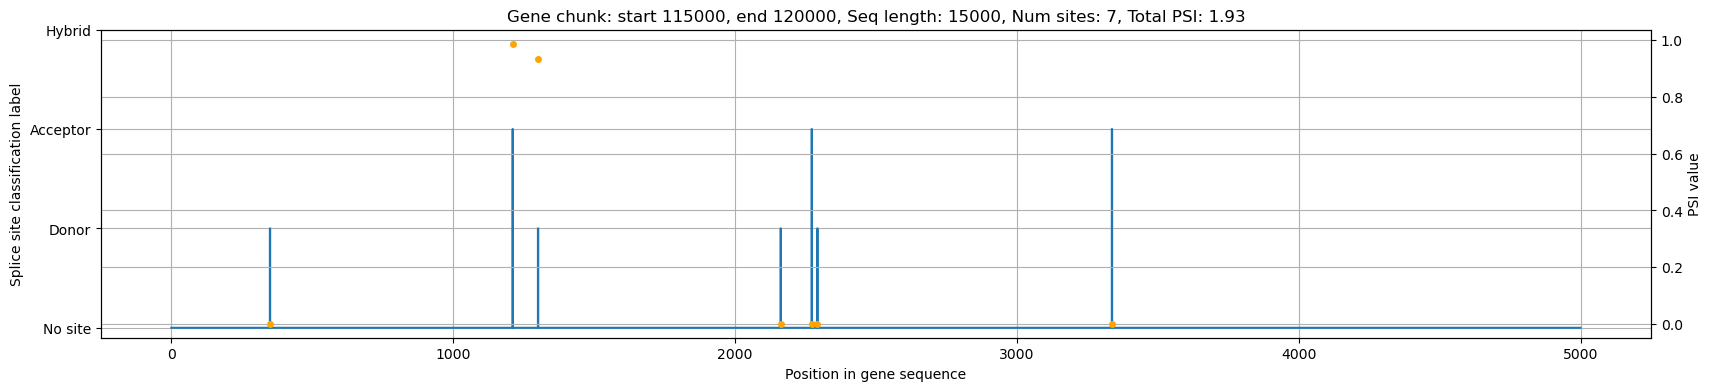

In [52]:
train_feat = train_feats[200]
fig, ax1 = plt.subplots(figsize=(20, 4))

ax1.plot(train_feat['cls'], drawstyle='steps-mid')
# ax1.set_title(f"Gene: {gene_sites['gene_id']}, Strand: {gene_sites['strand']}, Chrom: {gene_sites['chrom']}, Length: {len(rna_seq)}")
ax1.set_title(f"Gene chunk: start {train_feat['start']}, end {train_feat['end']}, Seq length: {len(train_feat['seq'])},"
              f" Num sites: {np.sum(train_feat['cls']>0)}, Total PSI: {np.nansum(train_feat['psi']):.2f}")
ax1.set_xlabel("Position in gene sequence")
ax1.set_ylabel("Splice site classification label")
ax1.set_yticks([0, 1, 2, 3])
ax1.set_yticklabels(['No site', 'Donor', 'Acceptor', 'Hybrid'])
ax1.grid()

ax2 = ax1.twinx()
ax2.plot(train_feat['psi'], drawstyle='steps', marker='o', markersize=4, color='orange')
ax2.set_ylabel("PSI value")
plt.xlabel("Position in gene sequence")
plt.ylabel("PSI value")
plt.grid()
plt.show()

In [ ]:
# show the statistics of rna_seq with splice sites
print(f"RNA sequence length: {len(rna_seq)}")
print(f"Number of classified splice sites: {np.sum(rna_cls > 0)}")
print(f"Number of splice sites with PSI values: {np.sum(~np.isnan(rna_psi))}")
rna_seq = np.array(list(rna_seq))
donor_residues = rna_seq[rna_cls == 1]
acceptor_residues = rna_seq[rna_cls == 2]
hybrid_residues = rna_seq[rna_cls == 3]
print(f"Donor residues: {''.join(donor_residues)}")
print(f"Acceptor residues: {''.join(acceptor_residues)}")
print(f"Hybrid residues: {''.join(hybrid_residues)}")
print(gene_sites['strand'])

RNA sequence length: 39690
Number of classified splice sites: 30
Number of splice sites with PSI values: 2
Donor residues: CGGGGGGGGGGGGG
Acceptor residues: GGGCCGGGGGGGGGGA
Hybrid residues: 
+


In [ ]:
tsv_file = os.path.join(os.getcwd(), "data/Human/E-MTAB-6814/majiq_heart_psi.tsv")

majiq_df = pd.read_csv(tsv_file, sep='\t', comment='#')
# print(majiq_df.head())

sj_columns = ["seqid", "strand", "gene_name", "gene_id", "event_type", 
              "ref_exon_start", "ref_exon_end", "start", "end", "is_intron", 
              "other_exon_start", "other_exon_end", 
              "is_denovo", "ref_exon_denovo", "other_exon_denovo", "event_denovo",]

for col in sj_columns:
    if col not in majiq_df.columns:
        raise ValueError(f"Column {col} not found in MAJIQ dataframe")
else:
    print(f"All columns are present, hooray!")
    
sam_columns = [col for col in majiq_df.columns if col not in sj_columns]
print(f"Found {len(sam_columns)} sample columns.")
assert len(sam_columns) % 4 == 0, "Number of sample columns is not a multiple of 4"

sam_names = [ ' '.join(col.split()[:-1]) for col in sam_columns[::4] ]
print(f"Total samples: {len(sam_names)}, sample names: {sam_names[:5]} ...")

spliser_gf = majiq_df.groupby('gene_id')
print(f"Total splice junctions: {len(majiq_df)}, total genes: {len(spliser_gf)}, example gene IDs: {list(spliser_gf.groups.keys())[:5]} ...")

All columns are present, hooray!
Found 200 sample columns.
Total samples: 50, sample names: ['1437sTS.Human.Heart.11w.Male.sorted', '1443sTSm.Human.Heart.CS23.Male.sorted', '2024sTSb.Human.Heart.10w.Male.sorted', '2027sTS.Human.Heart.CS21.Male.sorted', '2030sTSb.Human.Heart.CS22.Male.sorted'] ...
Total splice junctions: 136761, total genes: 6049, example gene IDs: ['ENSG00000000460.18', 'ENSG00000000971.18', 'ENSG00000001084.14', 'ENSG00000001617.13', 'ENSG00000001630.19'] ...


In [ ]:
# get the first group from gene_groups
gene_id = list(spliser_gf.groups.keys())[0]
gene_df = spliser_gf.get_group(gene_id)

print(f"Example gene ID: {gene_id}, number of splice junctions: {len(gene_df)}")
gene_lsv = {'gene_id': gene_id, 'num_sjs': len(gene_df),
            'chrom': gene_df['seqid'].iloc[0], 'strand': gene_df['strand'].iloc[0],
            'gene_name': gene_df['gene_name'].iloc[0],
            'event_type': gene_df['event_type'].tolist(),
            'ref_exon_start': gene_df['ref_exon_start'].values,
            'ref_exon_end': gene_df['ref_exon_end'].values,
            'start': gene_df['start'].values,
            'end': gene_df['end'].values,
            'is_intron': gene_df['is_intron'].tolist(),
            'other_exon_start': gene_df['other_exon_start'].values,
            'other_exon_end': gene_df['other_exon_end'].values,
            'is_denovo': gene_df['is_denovo'].tolist(),
            'ref_exon_denovo': gene_df['ref_exon_denovo'].tolist(),
            'other_exon_denovo': gene_df['other_exon_denovo'].tolist(),
            'event_denovo': gene_df['event_denovo'].tolist(),
           }


Example gene ID: ENSG00000000460.18, number of splice junctions: 19


In [ ]:
gene_meta = get_gene_meta_by_id(gene_id, gtf_db)
if gene_meta is None:
    raise ValueError(f"Gene {gene_id} not found in GTF database.")
    
gene_len = gene_meta.end - gene_meta.start + 1
genome_fasta = Fasta(genome_fasta)
# get gene transcript sequence from genome_fasta
rna_seq = genome_fasta[gene_meta.chrom][gene_meta.start-1:gene_meta.end]
print(f"Transcript length: {gene_len}, Gene sequence length: {len(rna_seq)}")


chr12 - 9092959 9102551
chr10 + 90750414 90775542
chr10 - 48001603 48055018
chr10 + 18098352 18200091
chr1 - 148003642 148025863
chr9 - 43064966 43133544
chr12 + 80799774 81072802
chr9 - 70432004 70497240
chr9 + 133046882 133309510
chr10 - 47157983 47174093
chr10 - 46657135 46681603
chr1 - 146032647 146082765
chr10 + 47894023 47949412
chr9 + 43684902 43924049
chr9 + 67968793 67987998
chr12 - 7187513 7245203
chr19 + 21264965 21308073
chr1 + 144146808 144224481
chr1 - 235613238 235667781
chr1 + 206516200 206637783
chr9 - 32552997 32573160
chr10 + 74033678 74035794
chr2 + 149632819 149883273
chr1 + 144811744 144830413
chr7 + 100547187 100611118
chr9 - 44998000 44998719
chr9 - 67792938 67794111
chr8 - 145486055 145515082
chr1 + 121107124 121129949
chr11 + 69061605 69182494
chr10 - 51224681 51371321
chr10 + 51187938 51192032
chr7 - 74880905 74988262
chr10 + 133747955 133773331
chr1 + 148900615 148903715
chr15 + 23435096 23448420
chr12 + 122516628 122631894
chr11 - 65545092 65547316
chr17 + 

ValueError: Gene ENSGR0000168939.6 not found in GTF database.

In [ ]:
# assert that the chrom of gene_info and gene_lsv are the same
assert gene_meta.chrom == gene_lsv['chrom'], f"Chromosome mismatch: {gene_meta.chrom} vs {gene_lsv['chrom']}"
assert gene_meta.strand == gene_lsv['strand'], f"Strand mismatch: {gene_meta.strand} vs {gene_lsv['strand']}"

gene_lsv['gene_seq'] = str(rna_seq)
gene_lsv['gene_start'] = gene_meta.start
gene_lsv['gene_end'] = gene_meta.end

assert all(gene_lsv['end'] - gene_lsv['start']), "Some start values are not smaller than end values"
assert all(gene_lsv['start'] - gene_lsv['gene_start']), "Some start values are smaller than gene start"
assert all(gene_lsv['end'] - gene_lsv['gene_start']), "Some end values are smaller than gene start"
assert all(gene_lsv['gene_end'] - gene_lsv['start']), "Some start values are larger than gene end"
assert all(gene_lsv['gene_end'] - gene_lsv['end']), "Some end values are larger smaller than gene end"

gene_lsv['rna_seq'] = gene_lsv['gene_seq'].upper()
gene_lsv['rna_seq'] = ''.join([nt if nt in 'ATGC' else 'N' for nt in gene_lsv['rna_seq']])

# if strand is negative, reverse complement the sequence
if gene_lsv['strand'] == '-':
    gene_lsv['rna_seq'] = reverse_complement(gene_lsv['rna_seq'])
    gene_lsv['rna_start'] = gene_lsv['gene_end'] - gene_lsv['end']
    gene_lsv['rna_end'] = gene_lsv['gene_end'] - gene_lsv['start']
else:
    gene_lsv['rna_start'] = gene_lsv['start'] - gene_lsv['gene_start']
    gene_lsv['rna_end'] = gene_lsv['end'] - gene_lsv['gene_start']


gene_lsv['sam_names'] = sam_names

for psi_col in ['raw_coverage', 'raw_psi_mean',  'raw_psi_std', 'bootstrap_psi_std']:
    sam_psi_cols = [f'{sam} {psi_col}' for sam in sam_names]
    gene_lsv[psi_col] = gene_df[sam_psi_cols].values # shape: (num_sjs, num_samples)
    # gene_lsv[psi_col] = np.nan_to_num(gene_lsv[psi_col], nan=0.0)

# classification
gene_lsv['rna_cls'] = np.zeros(len(gene_lsv['rna_seq']), dtype=np.int32)
gene_lsv['rna_cls_count'] = np.zeros(len(gene_lsv['rna_seq']), dtype=np.int32)
# usage
gene_lsv['rna_psi'] = np.zeros(len(gene_lsv['rna_seq']), dtype=np.float32)
gene_lsv['rna_psi_count'] = np.zeros(len(gene_lsv['rna_seq']), dtype=np.int32)

min_samples4cls = 0.10 # for classification
min_samples4psi = 0.10 # for psi usage
for rna_start, rna_end, psi, psi_std, coverage in zip(
        gene_lsv['rna_start'], gene_lsv['rna_end'], gene_lsv['raw_psi_mean'], gene_lsv['raw_psi_std'], gene_lsv['raw_coverage']):
    
    # psi_std and coverage are not used for now

    num_nans = np.sum(np.isnan(psi))
    if num_nans < len(psi) * (1 - min_samples4cls):
        gene_lsv['rna_cls'][rna_start] = 1
        gene_lsv['rna_cls'][rna_end] = 1
        gene_lsv['rna_cls_count'][rna_start] += 1
        gene_lsv['rna_cls_count'][rna_end] += 1
    else:
        print(f"Skipping junction at {rna_start}-{rna_end} for classification due to insufficient samples (NaNs: {num_nans}; Samples: {len(psi)}).")

    if num_nans < len(psi) * (1 - min_samples4psi):
        # average psi values across samples, ignoring NaNs
        psi = np.nanmean(psi)
        # add psi value to both start and end positions
        gene_lsv['rna_psi'][rna_start] += psi
        gene_lsv['rna_psi'][rna_end] += psi
        gene_lsv['rna_psi_count'][rna_start] += 1 
        gene_lsv['rna_psi_count'][rna_end] += 1
    else:
        print(f"Skipping junction at {rna_start}-{rna_end} for psi due to insufficient samples (NaNs: {num_nans}; Samples: {len(psi)}.")

print(gene_lsv['rna_cls'].max(), gene_lsv['rna_psi'].max())
print(f"Max rna_cls_count: {np.max(gene_lsv['rna_cls_count'])}, Max rna_psi_count: {np.max(gene_lsv['rna_psi_count'])}")
assert all(gene_lsv['rna_cls'] <= 1.1), "Some rna_cls values are greater than 1"
assert all(gene_lsv['rna_psi'] <= 1.1), "Some rna_psi values are greater than 1"


1 1.91419
Max rna_cls_count: 2, Max rna_psi_count: 2


AssertionError: Some rna_psi values are greater than 1

In [12]:
gene_lsv

{'gene_id': 'ENSG00000000460.18',
 'num_sjs': 19,
 'chrom': 'chr1',
 'strand': '+',
 'gene_name': 'FIRRM',
 'event_type': ['s',
  's',
  's',
  't',
  't',
  's',
  's',
  't',
  't',
  's',
  's',
  's',
  's',
  's',
  's',
  's',
  's',
  's',
  's'],
 'ref_exon_start': array([169806004, 169806004, 169806004, 169806004, 169806004, 169811558,
        169811558, 169811558, 169811558, 169812815, 169812815, 169816831,
        169816831, 169818641, 169818641, 169819406, 169819406, 169820958,
        169820958]),
 'ref_exon_end': array([169806253, 169806253, 169806253, 169806253, 169806253, 169811680,
        169811680, 169811680, 169811680, 169812910, 169812910, 169816944,
        169816944, 169818745, 169818745, 169819486, 169819486, 169821077,
        169821077]),
 'start': array([169806088, 169806088, 169806253, 169804240, 169801647, 169811680,
        169811681, 169806253, 169807930, 169812910, 169812911, 169816944,
        169816945, 169818745, 169818746, 169819486, 169819487, 16982

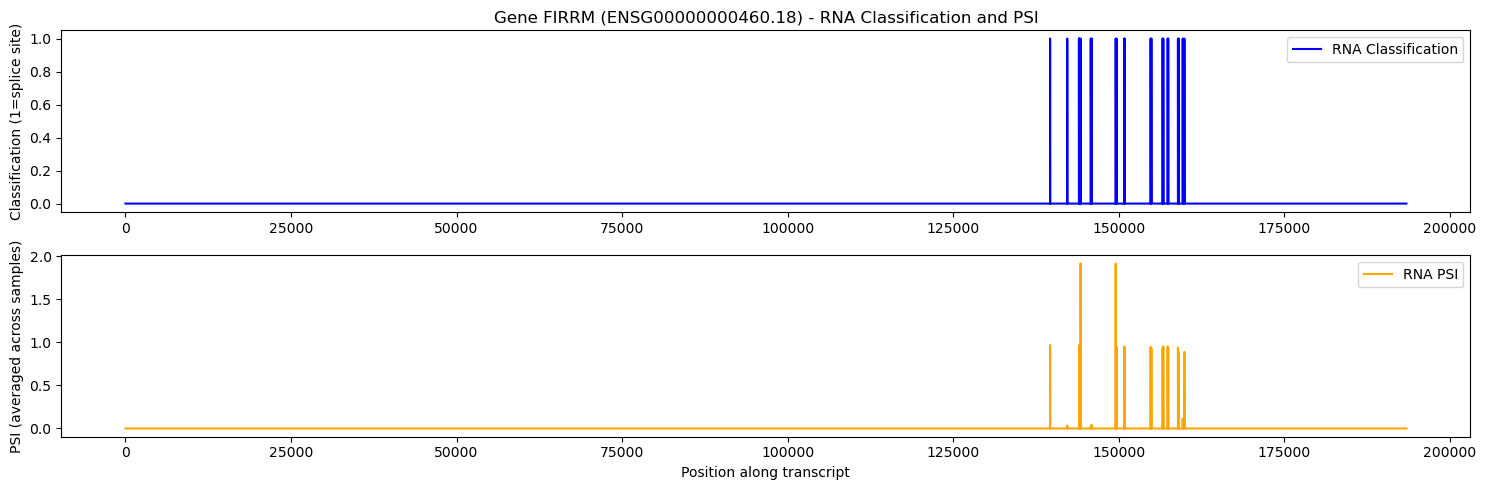

In [19]:
# plot the 1D array gene_lsv['rna_cls'] and gene_lsv['rna_psi'] with matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
plt.subplot(2, 1, 1)
plt.plot(gene_lsv['rna_cls'], label='RNA Classification', color='blue')
plt.title(f"Gene {gene_lsv['gene_name']} ({gene_lsv['gene_id']}) - RNA Classification and PSI")
plt.ylabel('Classification (1=splice site)')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(gene_lsv['rna_psi'], label='RNA PSI', color='orange')
plt.xlabel('Position along transcript')
plt.ylabel('PSI (averaged across samples)')
plt.legend()
plt.tight_layout()
plt.show()
                                                    

Seq Length: 193450
Chunk starts: [     0   5000  10000  15000  20000  25000  30000  35000  40000  45000
  50000  55000  60000  65000  70000  75000  80000  85000  90000  95000
 100000 105000 110000 115000 120000 125000 130000 135000 140000 145000
 150000 155000 160000 165000 170000 175000 180000 185000 188450]
Chunk ends: [  5000  10000  15000  20000  25000  30000  35000  40000  45000  50000
  55000  60000  65000  70000  75000  80000  85000  90000  95000 100000
 105000 110000 115000 120000 125000 130000 135000 140000 145000 150000
 155000 160000 165000 170000 175000 180000 185000 190000 193450]


In [11]:
print(len(train_feats))

39


In [ ]:
### Step 1: merge expression

GEX_files = glob.glob("raw_data/gene_count/*counts.txt")
# Initialize empty list to collect dataframes
df_list = []

for filepath in GEX_files:
    # Use filename (without extension) as sample name
    sample_name = filepath.split("/")[-1].split(".")[0]
    
    # Read file with gene ID as index
    df = pd.read_csv(filepath, sep="\t", header=None, index_col=0)
    df.columns = [sample_name]  # Rename single column to sample name
    
    df_list.append(df)

# Merge all DataFrames on index (gene ID)
merged_df = pd.concat(df_list, axis=1)

# Result: rows = genes, columns = samples
print("Merged expression matrix shape:", merged_df.shape)

# Step 2: Load database
db = gffutils.FeatureDB(gtf_db)

# Step 3: Calculate gene lengths (union of exon intervals per gene)
gene_lengths = {}
for gene_id in db.features_of_type('gene'):
    try:
        exons = list(db.children(gene_id, featuretype='exon', order_by='start'))
        if not exons:
            continue
        # Union exon spans
        intervals = []
        for exon in exons:
            intervals.append((exon.start, exon.end))
        # Merge overlapping intervals
        intervals.sort()
        merged = []
        current_start, current_end = intervals[0]
        for rna_start, rna_end in intervals[1:]:
            if rna_start <= current_end:
                current_end = max(current_end, rna_end)
            else:
                merged.append((current_start, current_end))
                current_start, current_end = rna_start, rna_end
        merged.append((current_start, current_end))
        # Sum total length
        total_length = sum(end - start + 1 for start, end in merged)
        gene_lengths[gene_id.id] = total_length
    except Exception as e:
        print(f"Failed on gene {gene_id.id}: {e}")

# Step 4: Save as TSV
length_df = pd.DataFrame.from_dict(gene_lengths, orient='index', columns=['length'])
length_df.index.name = 'gene_id'
length_df.to_csv("gencode.v48.gene_lengths.tsv", sep='\t')

# Load expression matrix
# Rows = genes, Columns = samples
expr_df = merged_df.iloc[0:-5, :]

# Load gene lengths (must match index of expr_df)
# Example format: gene_id \t length
gene_lengths = length_df['length']

# Filter to common genes
common_genes = expr_df.index.intersection(gene_lengths.index)
expr_df = expr_df.loc[common_genes]
gene_lengths = gene_lengths.loc[common_genes]

# Normalize counts to TPM
def counts_to_tpm(counts, lengths):
    rpk = counts.div(lengths, axis=0)  # reads per kilobase
    scaling_factor = rpk.sum(axis=0) / 1e6  # per sample
    return rpk.div(scaling_factor, axis=1)

tpm_df = counts_to_tpm(expr_df, gene_lengths)

# Save result
tpm_df.to_csv("combined_expression_matrix.TPM.tsv", sep='\t', float_format='%.3f')

In [3]:
## read expression table for generation
tpm_df = pd.read_csv("combined_expression_matrix.TPM.tsv", sep='\t').set_index('gene_id')
gene_select = tpm_df.std(axis = 1).nlargest(10).index

tpm_df = tpm_df.loc[gene_select, :]
normalized_df = tpm_df.sub(tpm_df.min(axis=1), axis=0).div(tpm_df.max(axis=1) - tpm_df.min(axis=1), axis=0).fillna(0)
normalized_df = normalized_df.round(3)

#normalized_df.to_csv("var_top10_exp.TPM.tsv", sep='\t')

In [ ]:
odr=4
plot_one_hot_and_labels_zoom(training_input[odr], training_label[odr], zoom_start=0, zoom_end=15000, title="Sequence and Labels")

In [ ]:
def Write_Training_Data_From_EXP_PSI(normalized_df, _out_path="default_training_data.pt"):
    training_input = []
    training_label = []
    genome = Fasta(genome_fasta)

    for sample_id in normalized_df.columns:
        print(f"Processing sample: {sample_id}")
    
        # Find TSV files matching this sample_id
        tsv_files = glob.glob(f"raw_data/PSI/*{sample_id}*.psi.tsv")
        if not tsv_files:
            print(f"  No PSI TSV files found for sample {sample_id}, skipping.")
            continue
    
        for MAJIQ_TSV in tsv_files:
            #print(f"  Processing file: {MAJIQ_TSV}")
            try:
                majiq_df = pd.read_csv(MAJIQ_TSV, sep="\s+")[0:25]  # optionally limit for speed
            except Exception as e:
                print(f"Failed to load {MAJIQ_TSV}: {e}")
                continue

            # Group rows by gene_id
            gene_groups = defaultdict(list)
            for _, row in majiq_df.iterrows():
                gene_groups[row['gene_id']].append(row)

            for gene, rows in gene_groups.items():
                psi_map = {}
                # Merge PSI values from all LSVs of the same gene
                for row in rows:
                    psi_values = list(map(float, row['mean_psi_per_lsv_junction'].split(';')))
                    junction_coords = row['junctions_coords'].split(';')
                    for junc, psi in zip(junction_coords, psi_values):
                        try:
                            start, end = parse_coords(junc)
                            psi_map[start] = psi
                            psi_map[end] = psi
                        except Exception as e:
                            print(f"Failed to parse junction '{junc}': {e}")
                            continue
            
                # Get gene region
                result = get_gene_bounds_by_id(gene, gtf_db)
                if result is None:
                    print(f"Skipping {gene} – gene bounds not found.")
                    continue
                chrom, strand, tss, tes = result
                #print(f"Gene: {gene} – Coordinates: {chrom} {strand} {tss} {tes}")

                # Get expression vector for this block by sample
                expr_vec = normalized_df.loc[:, sample_id].values  # shape: (10,)
                expr_tensor = torch.tensor(expr_vec, dtype=torch.float32).view(-1, 1).repeat(1, BLOCK_SIZE)  # [10, 15000]
                
                # Create sequence blocks
                start = min(tss, tes)
                end = max(tss, tes)
                blocks = make_blocks(start, end, chrom, genome, PADDING, BLOCK_SIZE)
                
                for block_start, block_end, seq in blocks:
                    if seq.count('N')>= PADDING:
                        print (seq.count('N'), "out of ", BLOCK_SIZE, "Skip")
                        continue
                    seq_tensor = torch.tensor(one_hot_encode(seq), dtype=torch.float32)  # [4, 15000]
                    X = torch.cat([seq_tensor, expr_tensor], dim=0)  # [14, 15000]
                    y = torch.tensor(assign_labels(block_start, block_end, psi_map, PADDING, BLOCK_SIZE), dtype=torch.float32)
                    training_input.append(X)
                    training_label.append(y)
    torch.save({'X': training_input, 'y': training_label}, _out_path)
    print(f"Saved {len(training_input)} samples to {_out_path}")
    return None

In [10]:
normalized_df = pd.read_csv("var_top10_exp.TPM.tsv", sep='\t').set_index('gene_id')
#normalized_df = normalized_df.iloc[:, 0:20] 
normalized_df = normalized_df.loc[:, ["2027sTS"]] #
output_name = "Top10_20S_training_data_sequece_exp.pt"
Write_Training_Data_From_EXP_PSI(normalized_df, output_name)#"Top10_20S_training_data_sequece_exp.pt")

Processing sample: 5818sTS
Processing sample: 3672sTS
Processing sample: 1443sTSm
Processing sample: 5952sTS
9896 out of  15000 Skip
14896 out of  15000 Skip
15000 out of  15000 Skip
15000 out of  15000 Skip
15000 out of  15000 Skip
15000 out of  15000 Skip
15000 out of  15000 Skip
15000 out of  15000 Skip
15000 out of  15000 Skip
10104 out of  15000 Skip
5104 out of  15000 Skip
Processing sample: 5905sTS
Processing sample: 2110sTS
Processing sample: 5645sTS
Processing sample: 6100sTS
Processing sample: 2113sTS
Processing sample: 3589sTS
Processing sample: 5942sTS
9896 out of  15000 Skip
14896 out of  15000 Skip
15000 out of  15000 Skip
15000 out of  15000 Skip
15000 out of  15000 Skip
15000 out of  15000 Skip
15000 out of  15000 Skip
15000 out of  15000 Skip
15000 out of  15000 Skip
10104 out of  15000 Skip
5104 out of  15000 Skip
Processing sample: 5822sTS
Processing sample: 5664sTS
Processing sample: 3643sTS
Processing sample: 5628sTS
Processing sample: 6107sTS
Processing sample: 35

In [22]:
!aws s3 cp Top10_20S_training_data_sequece_exp.pt s3://research.luffingfuturellc/Pangolin/

upload: ./Top10_20S_training_data_sequece_exp.pt to s3://research.luffingfuturellc/Pangolin/Top10_20S_training_data_sequece_exp.pt


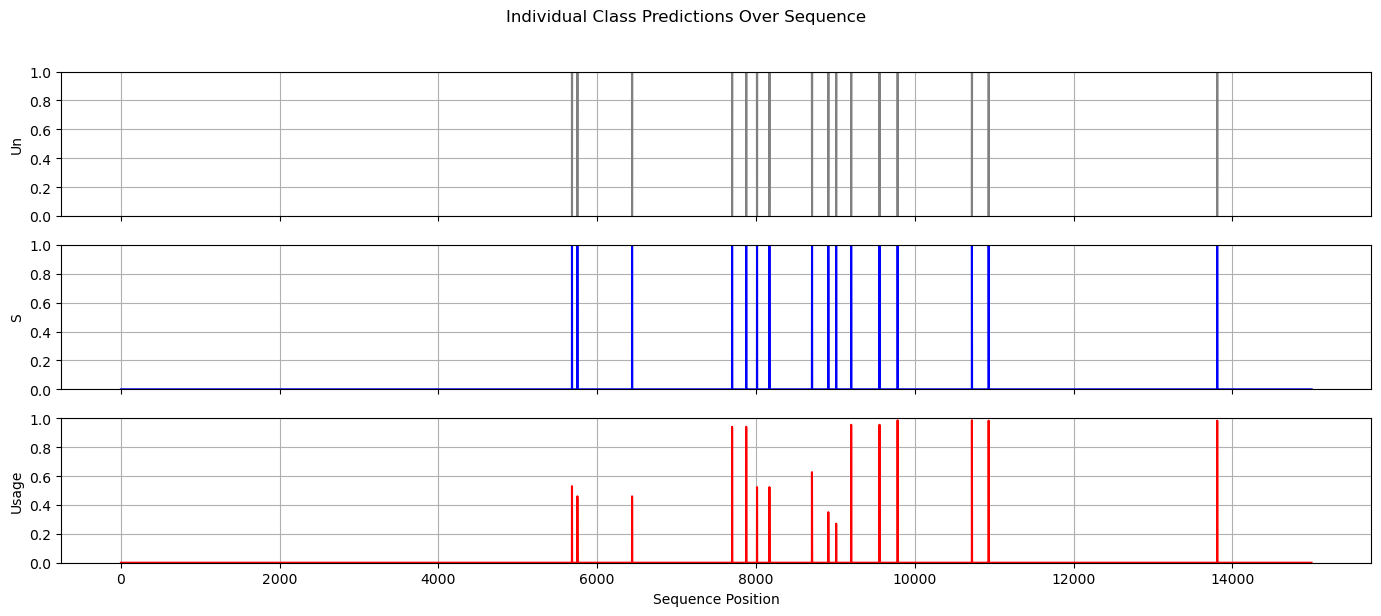

In [ ]:
def count_N_from_one_hot(one_hot_tensor):
    # one_hot_tensor: torch.Tensor of shape [4, length]
    # Sum over rows (channels), find where the sum is 0
    zero_cols = torch.sum(one_hot_tensor, dim=0) == 0
    return torch.sum(zero_cols).item() 
Plot_2D_Array(training_label[1])

## validation from PSI to Label

In [6]:
def Plot_2D_Array(array):
    ## 2D torch tensor, shape =  torch.Size([3, 15000])
    # Plot
    fig, axes = plt.subplots(3, 1, figsize=(14, 6), sharex=True)
    colors = ['gray', 'blue', 'red']
    labels = ['Un', 'S', 'Usage']
    # X-axis (sequence positions)
    x = np.arange(len(array[0]))
    
    for i in range(3):
        axes[i].plot(x, array[i], color = colors[i])
        axes[i].set_ylabel(labels[i])
        axes[i].set_ylim(0, 1)
        axes[i].grid(True)
    
    axes[-1].set_xlabel("Sequence Position")
    fig.suptitle("Individual Class Predictions Over Sequence", y=1.02)
    plt.tight_layout()
    plt.show()
    return None

In [24]:
## validation from PSI to Label
#class_labels = assign_labels(block_start, block_end, psi_map, PADDING, BLOCK_SIZE)
#Plot_2D_Array(class_labels)
#data["X"]

In [7]:
# Load preprocessed training data
data = torch.load(output_name, weights_only=True)
#data = torch.load("2027sTS_training_data_sequece_exp.pt", weights_only=True)
training_input =  torch.stack(data['X'])  # Each: [N, 4, 15000] # Input:
training_label = torch.stack(data['y'])  # Each: [N, 12, 5000] # Label:

0


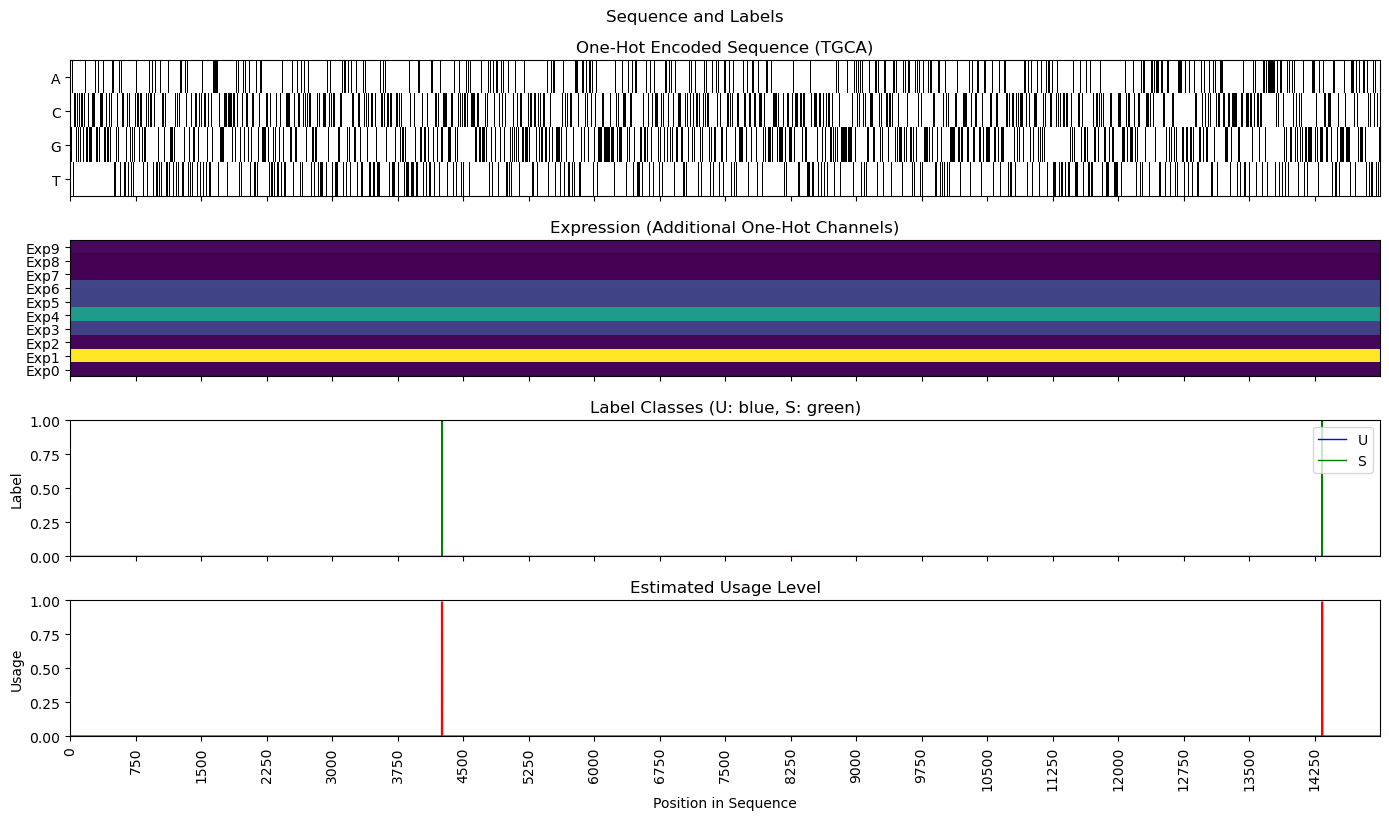

1


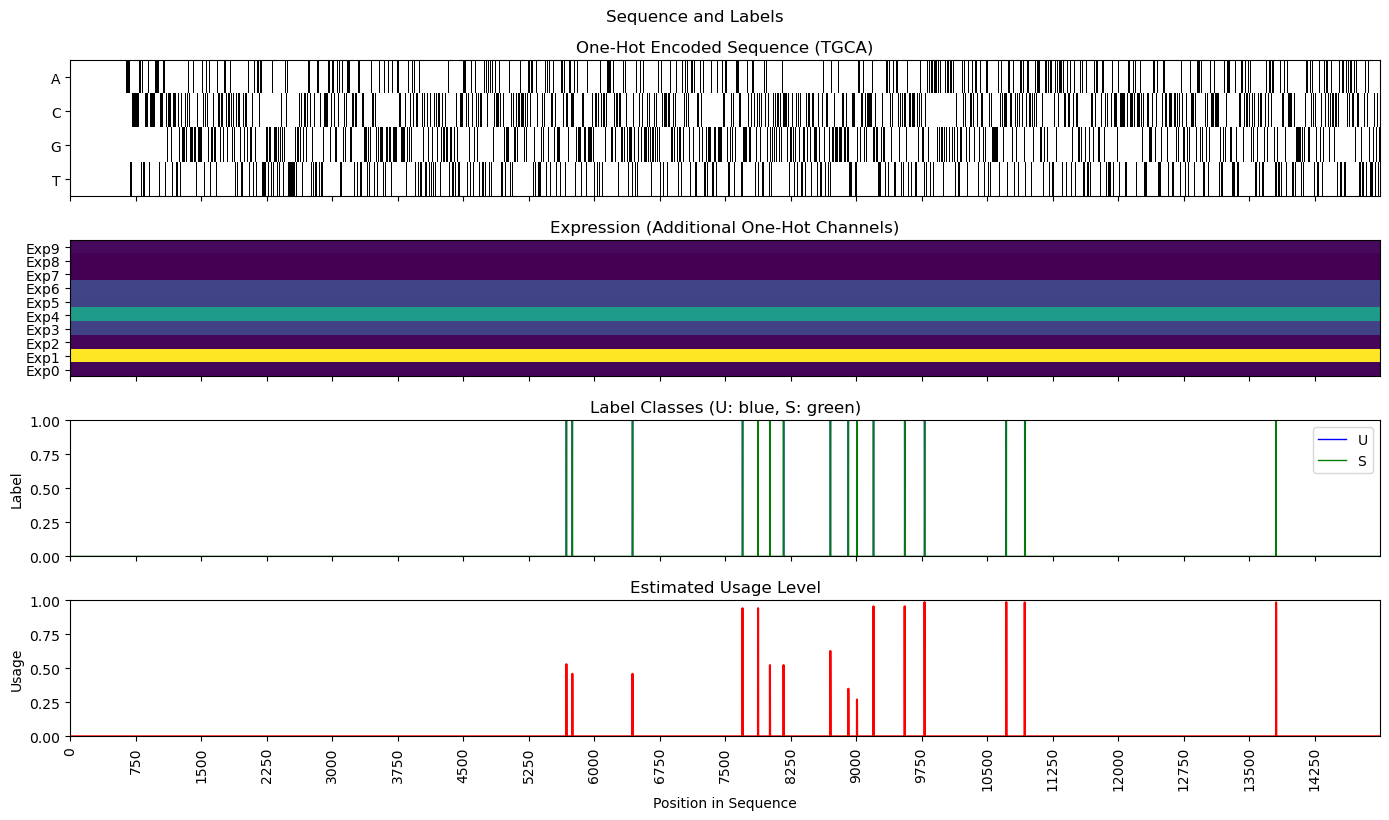

In [9]:
## BCE weight = 1
cor_start = 0
cor_end = 15000 #7704

for i in range(0, 2, 1):
    print (i)
    plot_one_hot_and_labels_zoom(training_input[i], training_label[i], 
                             zoom_start=cor_start, zoom_end=cor_end, title="Sequence and Labels")
    #break

In [ ]:
## Test

In [ ]:
gene_id = "ENSG00000070019.5"
get_gene_bounds(gene_id, gtf_db)
#print (tss, tes, chrom, genome, PADDING)
#majiq_df.head(0)
gene_id = "ENSG00000162365.12"
get_gene_bounds(gene_id, gtf_db)

('chr1', '+', 47137435, 47149735)

In [31]:
print(f"Prepared {len(training_data)} training blocks.")


Prepared 105 training blocks.


In [11]:
training_data[0][0]
training_data[0][1]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(3, 15000))

In [52]:
data_for_plot[1][:, 0].argmax()
data_for_plot[1][:, 1].argmax()
data_for_plot[1][:, 2].argmax()

np.int64(8811)

In [22]:
data_for_plot[1][:, 8811]

array([0.    , 1.    , 0.9877])

In [24]:
#decode_one_hot(data_for_plot[0].T)